In [1]:
import os
import pickle

import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as D

from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

PATH_DATA = os.path.join('data', 'hw2_q2.pkl')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
with open(PATH_DATA, 'rb') as file:
    dataset = pickle.load(file)
    
xs_train = dataset['train']
xs_val = dataset['test']

In [3]:
batch_size = 256

def collate_fn(xs):
    xs = torch.LongTensor(xs)
    xs = xs.permute(0, 3, 1, 2)
    return xs

train_data_loader = data.DataLoader(
    dataset=xs_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_fn
)
val_data_loader = data.DataLoader(
    dataset=xs_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    collate_fn=collate_fn
)

In [42]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3,
        stride=stride, padding=1, bias=False
    )

class ResBlock(nn.Module):
    def __init__(self, in_planes, planes):
        super(ResBlock, self).__init__()
        
        self.conv1 = conv3x3(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, in_planes)
        self.bn2 = nn.BatchNorm2d(in_planes)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activ(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.activ(out)

        return out


class ResNet(nn.Module):
    def __init__(self, in_planes, planes, layers_cnt):
        super(ResNet, self).__init__()
        
        layers = [conv3x3(in_planes, planes)]
        layers += [ResBlock(planes, planes) for _ in range(layers_cnt)]
        layers += [conv3x3(planes, 2 * in_planes)]
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x
    
    
class CouplingLayer(nn.Module):
    def __init__(self, mask, in_planes, h, w, planes, layers):
        super(CouplingLayer, self).__init__()
        
        self.mask = mask.clone()
        
        self.resnet = ResNet(in_planes, planes, layers)
        
    def forward(self, x):
        z = self.mask * x
        log_s, t = self.resnet(z).split(z.shape[1], dim=1)
        log_s = torch.tanh(log_s)
        z = z + (1 - self.mask) * (torch.exp(log_s) * x + t)
        logdet = (log_s * (1.0 - self.mask)).flatten(1).sum(dim=1, keepdim=True)
        return z, logdet
            
    def reconstruction(self, x):
        z = self.mask * x
        log_s, t = self.resnet(z).split(z.shape[1], dim=1)
        log_s = torch.tanh(log_s)
        z = z + (1 - self.mask) * (x - t) / torch.exp(log_s)
        return z

In [43]:
class ActNorm(nn.Module):
    EPS = 1e-9
    
    def __init__(self, c, h, w):
        super(ActNorm, self).__init__()
        
        self.w = nn.Parameter(torch.ones([1, c, h, w]))
        self.b = nn.Parameter(torch.zeros([1, c, h, w]))
        
    def forward(self, x):
        x = x * self.w + self.b
        logdet = torch.log(self.w.abs() + ActNorm.EPS).flatten(1).sum(dim=1, keepdim=True)
        return x, logdet
    
    def reconstruction(self, x):
        x = (x - self.b) / self.w
        return x

In [44]:
class RealNVP(nn.Module):
    EPS = 1e-6
    
    def __init__(self, in_planes, h, w, planes=32, layers=4):
        super(RealNVP, self).__init__()
        
        self.layers1 = nn.ModuleList()
        mask = self.get_checkerboard_mask(in_planes, h, w)
        for _ in range(4):
            self.layers1.append(CouplingLayer(mask, in_planes, h, w, planes, layers))
            self.layers1.append(ActNorm(in_planes, h, w))
            mask = 1.0 - mask
            
        in_planes, h, w = in_planes * 4, h // 2, w // 2
        
        self.layers2 = nn.ModuleList()
        mask = self.get_channel_split_mask(in_planes, h, w)
        for _ in range(3):
            self.layers2.append(CouplingLayer(mask, in_planes, h, w, planes, layers))
            self.layers2.append(ActNorm(in_planes, h, w))
            mask = 1.0 - mask
        
        self.layers3 = nn.ModuleList()
        mask = self.get_checkerboard_mask(in_planes, h, w)
        for _ in range(3):
            self.layers3.append(CouplingLayer(mask, in_planes, h, w, planes, layers))
            self.layers3.append(ActNorm(in_planes, h, w))
            mask = 1.0 - mask
            
        in_planes, h, w = in_planes * 4, h // 2, w // 2
            
        self.layers4 = nn.ModuleList()
        mask = self.get_channel_split_mask(in_planes, h, w)
        for _ in range(3):
            self.layers4.append(CouplingLayer(mask, in_planes, h, w, planes, layers))
            self.layers4.append(ActNorm(in_planes, h, w))
            mask = 1.0 - mask
            
        self.layers5 = nn.ModuleList()
        mask = self.get_checkerboard_mask(in_planes, h, w)
        for i in range(3):
            self.layers5.append(CouplingLayer(mask, in_planes, h, w, planes, layers))
            self.layers5.append(ActNorm(in_planes, h, w))
            mask = 1.0 - mask
            
    def get_checkerboard_mask(self, c, h, w):
        a = np.ones([1, c, h, w], dtype=np.bool)
        b = np.ones([1, c, h, w], dtype=np.bool)
        a[:, :, np.arange(1, h, 2), :] = False 
        b[:, :, :, np.arange(0, w, 2)] = False
        return torch.tensor(a ^ b, dtype=torch.float32, device=device)

    def get_channel_split_mask(self, c, h, w):
        mask = torch.zeros([1, c, h, w], dtype=torch.float32, device=device)
        idx = t = np.arange(0, c // 4) * 4
        idx = np.stack((idx, idx + 1), axis=1).reshape(-1)
        mask[:, idx, :, :] = 1.0
        return mask
            
    def logit(self, x):
        z = torch.log(x) - torch.log(1.0 - x)
        diag = (1.0 / x + 1.0 / (1.0 - x)).abs().flatten(start_dim=1)
        logdet = torch.log(diag + RealNVP.EPS).sum(dim=1, keepdim=True)
        return z, logdet    
        
    def logit_reconstruction(self, x):
        z = torch.exp(x)
        return z / (z + 1.0)

    def dequantize(self, x, alpha=0.05):
        z = alpha + (1.0 - alpha) * x / 4.0
        diag = (torch.ones_like(x) * (1.0 - alpha) / 4.0).flatten(start_dim=1)
        logdet = torch.log(diag.abs()).sum(dim=1, keepdim=True)
        return z, logdet
        
    def dequantize_reconstruction(self, x, alpha=0.05):
        return 4.0 * (x - alpha) / (1.0 - alpha)

    def preprocess(self, x, alpha=0.05):
        deq, logdet1 = self.dequantize(x, alpha)
        z, logdet2 = self.logit(deq)
        logdet = logdet1 + logdet2
        return z, logdet
        
    def preprocess_reconstruction(self, x, alpha=0.05):
        z = self.logit_reconstruction(x)
        z = self.dequantize_reconstruction(z, alpha)
        return z
    
    def squeeze(self, x):
        n, c, h, w = x.shape
        return F.unfold(x, (2, 2), stride=2).reshape(n, 4 * c, h // 2, w // 2)

    def unsqueeze(self, x):
        n, c, h, w = x.shape
        return F.fold(x.reshape(n, c, -1), (h * 2, w * 2), (2, 2), stride=2)
            
    def forward(self, x):
        x, logdet = self.preprocess(x)
        
        for layer in self.layers1:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet

        x = self.squeeze(x)
        
        for layer in self.layers2:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet
        for layer in self.layers3:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet

        x = self.squeeze(x)
        
        for layer in self.layers4:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet
        for layer in self.layers5:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet

        x = self.unsqueeze(x)
        x = self.unsqueeze(x)
    
        return x, logdet
        
    def reconstruction(self, x):
        x = self.squeeze(x)
        x = self.squeeze(x)
        
        for layer in reversed(self.layers5):
            x = layer.reconstruction(x)
        for layer in reversed(self.layers4):
            x = layer.reconstruction(x)
            
        x = self.unsqueeze(x)
        
        for layer in reversed(self.layers3):
            x = layer.reconstruction(x)
        for layer in reversed(self.layers2):
            x = layer.reconstruction(x)
            
        x = self.unsqueeze(x)
        
        for layer in reversed(self.layers1):
            x = layer.reconstruction(x)
            
        x = self.preprocess_reconstruction(x)
        
        return x

In [45]:
class MLLELoss(nn.Module):    
    def __init__(self):
        super(MLLELoss, self).__init__()

    def forward(self, z, logdet):
        m = D.normal.Normal(0, 1)
        log_pz = m.log_prob(z) 
        log_pz = log_pz.flatten(start_dim=1).sum(dim=1, keepdim=True)
        loss = -log_pz - logdet
        loss = loss.mean()
        return loss

In [106]:
def train(model, criterion, optimizer, scheduler, epochs):
    losses_train = []
    losses_val = []
    for i in trange(epochs):
        losses = []
        model.train()
        for xs in train_data_loader:
            xs = xs.to(device)
            
            optimizer.zero_grad()

            z, logdet = model(xs)
            loss = criterion(z, logdet)

            losses.append(loss.item())

            loss.backward()
            optimizer.step()

        losses_train.append(np.array(losses).mean())

        losses = []
        model.eval()
        with torch.no_grad():
            for xs in val_data_loader:
                xs = xs.to(device)
                
                z, logdet = model(xs)
                loss = criterion(z, logdet)

                losses.append(loss.item())

        losses_val.append(np.array(losses).mean())
        
        if scheduler:
            scheduler.step()

    plt.plot(range(epochs), losses_train, label="train")
    plt.plot(range(epochs), losses_val, label="val")
    plt.xlabel('epoch num')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [107]:
def show_interpolation(model, n=5, m=10):
    sample_ids = list(range(n))
    samples_a = xs_train[sample_ids]
    samples_b = xs_train[sample_ids[-1:] + sample_ids[:-1]]
    samples_a = collate_fn(samples_a).to(device)
    samples_b = collate_fn(samples_b).to(device)
    
    images = []
    with torch.no_grad():
        for i in range(n):
            a, b = samples_a[i], samples_b[i]
            (za, _), (zb, _) = model(a[None, :]), model(b[None, :])
            for j in range(m):
                x = model.reconstruction(za + (zb - za) * j / (m - 1))
                x = x.permute(0, 2, 3, 1).cpu().numpy()[0]
                x = x[:, :, [2, 1, 0]]
                images.append(x)
            
    images = np.array(images)
    images /= 4
    images = np.clip(images, 0, 1)
    
    f, axarr = plt.subplots(n, m)
    f.set_figheight(15)
    f.set_figwidth(15)
    for i, img in enumerate(images):
        axarr[n - 1 - i // m, i % m].imshow(img)
        axarr[n - 1 - i // m, i % m].axis('off')
    plt.show()

In [108]:
def show_sampels(model, n=100):
    m = D.normal.Normal(0, 1)
    z = m.sample([100, 3, 32, 32]).to(device)
    
    with torch.no_grad():
        images = model.reconstruction(z)
        images = images.permute(0, 2, 3, 1).cpu().numpy()
        images = images[:, :, :, [2, 1, 0]]
        
    images /= 4
    images = np.clip(images, 0, 1)
    
    n = int(np.ceil(np.sqrt(n)))
    f, axarr = plt.subplots(n, n)
    f.set_figheight(15)
    f.set_figwidth(15)
    for i, img in enumerate(images):
        axarr[i // n, i % n].imshow(img)
        axarr[i // n, i % n].axis('off')
    plt.show()

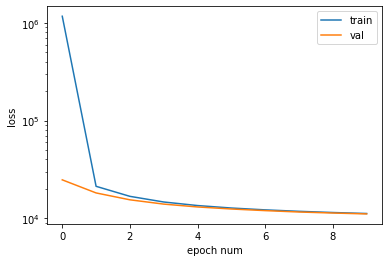

In [76]:
epochs = 10 # 100
lr = 0.0005
w_l2 = 0

model = RealNVP(3, 32, 32, planes=32, layers=4)
model.to(device)

criterion = MLLELoss()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)

train(model, criterion, optimizer, None, epochs)

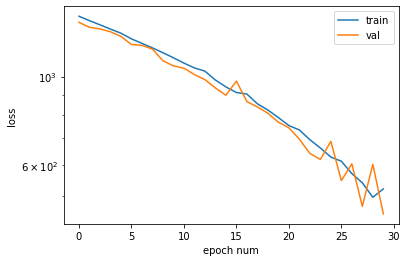

In [128]:
train(model, criterion, optimizer, None, 30)

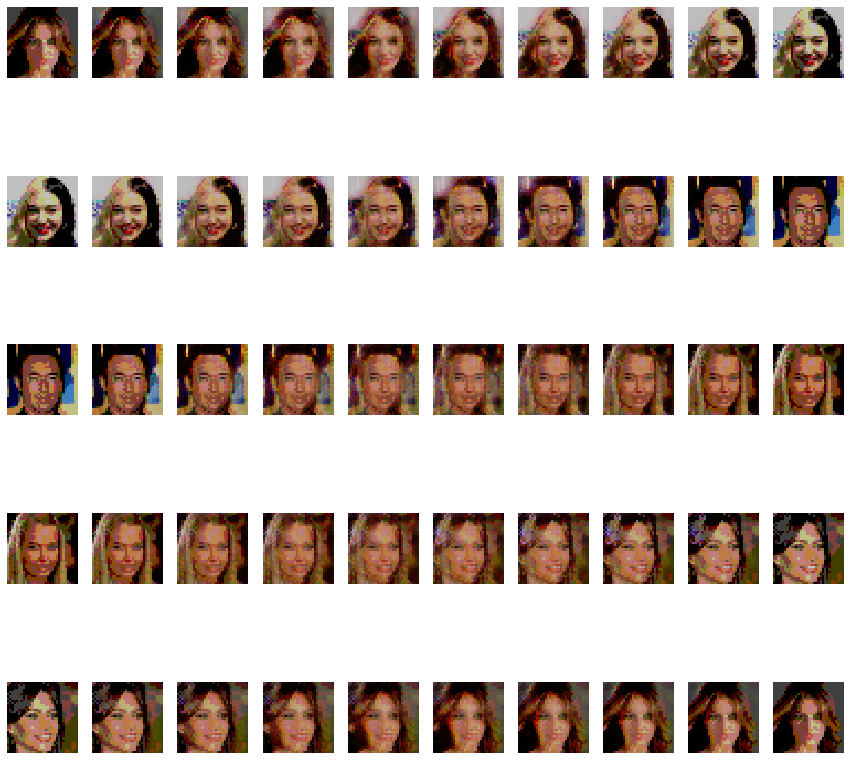

In [129]:
model.eval()
show_interpolation(model)

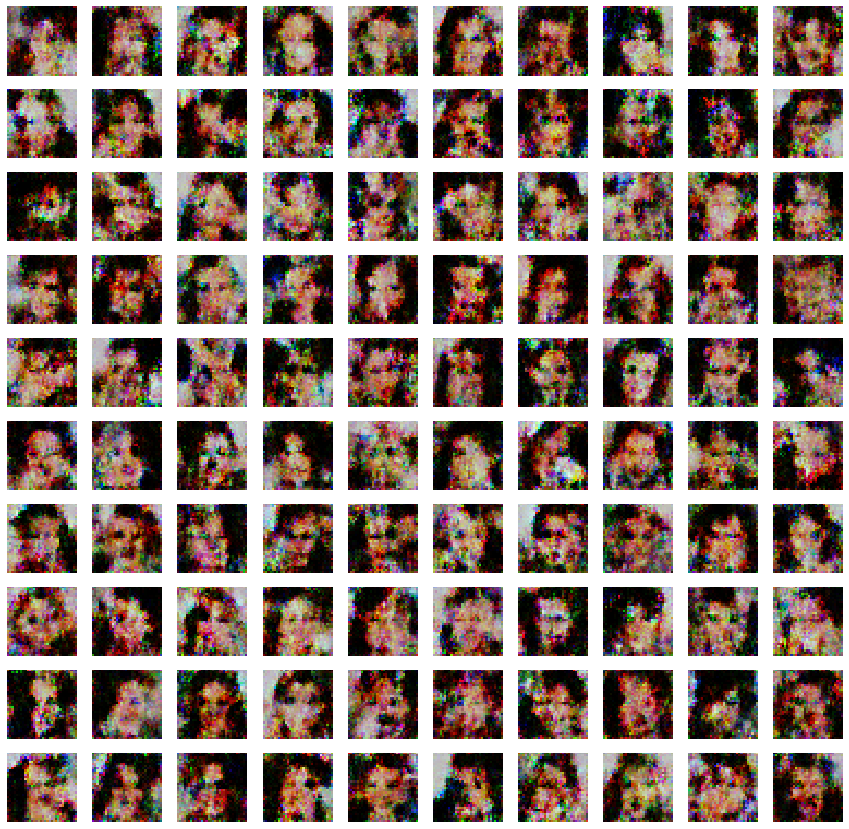

In [130]:
show_sampels(model)